In [48]:
# test edit
import torch

In [49]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [50]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
#from online: the mean of MNIST is 0.1307, the std 0.3081
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

trainset = torchvision.datasets.MNIST(root= '../data', train=True,
                                        download=True, transform=transform)
#keep batches in 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

## Attempted Wavelets:

Haar: Fully Connected 1(9216, 128)
Daubechies 1: Fully Connected 1 (9216,128)
Daubechies 2: Fully Connected 2(7744, 128)

In [59]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

In [60]:
import torch
import torch.nn as nn
import numpy as np

def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('bior2.2')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [64]:
net = Net()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in testloader:
            output = net(data)
            testing_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    test_loss.append(testing_loss / len(testloader.dataset))
    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Loss: %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, testing_loss / len(testloader.dataset), correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.910
[1,  2000] running loss: 0.234
[1,  3000] running loss: 0.104
[1,  4000] running loss: 0.072
[1,  5000] running loss: 0.047
[1,  6000] running loss: 0.030
[1,  7000] running loss: 0.031
[1,  8000] running loss: 0.020
[1,  9000] running loss: 0.019
[1, 10000] running loss: 0.015
[1, 11000] running loss: 0.013
[1, 12000] running loss: 0.012
[1, 13000] running loss: 0.011
[1, 14000] running loss: 0.009
[1, 15000] running loss: 0.007
Epoch 1, Training Loss:  0.250, Testing Loss: 0.116, Testing Accuracy: 0.965
[2,  1000] running loss: 0.111
[2,  2000] running loss: 0.055
[2,  3000] running loss: 0.038
[2,  4000] running loss: 0.027
[2,  5000] running loss: 0.020
[2,  6000] running loss: 0.021
[2,  7000] running loss: 0.014
[2,  8000] running loss: 0.013
[2,  9000] running loss: 0.011
[2, 10000] running loss: 0.013
[2, 11000] running loss: 0.008
[2, 12000] running loss: 0.009
[2, 13000] running loss: 0.008
[2, 14000] running loss: 0.006
[2, 15000] running loss:

Text(0, 0.5, 'Error')

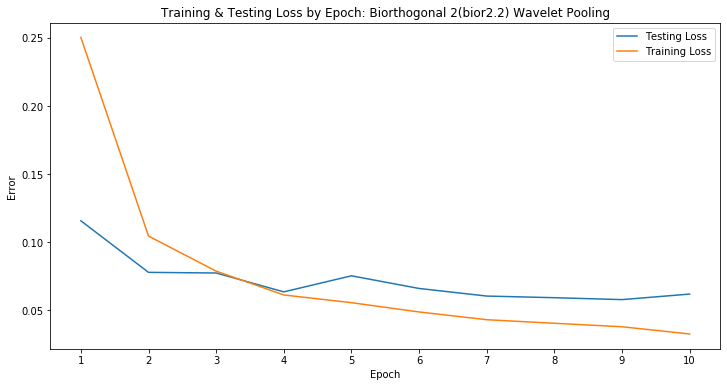

In [66]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), test_loss, label = 'Testing Loss')
plt.plot(np.arange(1, 11, step=1), train_loss, label = 'Training Loss')
plt.title('Training & Testing Loss by Epoch: Biorthogonal 2(bior2.2) Wavelet Pooling')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [67]:
train_loss

[0.25026597545406737,
 0.10455214137010602,
 0.07883390824151587,
 0.06137519277042629,
 0.05570115791120794,
 0.04890103073240822,
 0.043206150763645534,
 0.04058872089014112,
 0.03804094681314449,
 0.03274396520643118]

In [68]:
test_loss

[0.11575877110226275,
 0.07794411553467306,
 0.07747734736781314,
 0.06362898930518703,
 0.07541608321099325,
 0.06613323767914053,
 0.06055719472651712,
 0.059353598706451904,
 0.05795201967478622,
 0.0620041708774047]

In [69]:
run_loss

[0.910041346167447,
 0.23401326426956803,
 0.10449998820360634,
 0.07205963810657703,
 0.046741644759909835,
 0.030233432894808326,
 0.031149674747869928,
 0.01975309447672241,
 0.018874474183501157,
 0.01480233658215933,
 0.013242637262546767,
 0.01222413876773959,
 0.010679239488832046,
 0.008781353654646279,
 0.007398704450411598,
 0.11089192922183475,
 0.05470230269034167,
 0.03845830674495376,
 0.02701758002531942,
 0.020439485244436263,
 0.02110045557068718,
 0.01403770404732258,
 0.012630411282383985,
 0.01127785364808087,
 0.012849950512973192,
 0.008301264158487798,
 0.008517729123962417,
 0.008151965390147717,
 0.005944165336998233,
 0.005580817292868595,
 0.08484982017206917,
 0.03941594769607069,
 0.02456099688636463,
 0.021851744805279877,
 0.017573393450617255,
 0.013519407203754883,
 0.013002395944523735,
 0.007441964068313034,
 0.006889094983066433,
 0.008240956107011034,
 0.006642469795760416,
 0.007110119401131342,
 0.006794269684557876,
 0.0053333064539724424,
 0.004